<a href="https://colab.research.google.com/github/algomaster99/meta-btp/blob/master/Engineering_Stress%2C_Strain_%3E_True_Stress%2C_Strain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialisation

### Dependencies

In [159]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
from sklearn.linear_model import LinearRegression

### Dataset path

In [160]:
from google.colab import drive
drive.mount('/content/drive')

PATH_TO_DATA = '/content/drive/MyDrive/meta-btp/tensile_test_data.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow $ True Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $s \rightarrow$ Engineering Stress
- $\theta \rightarrow$ Work hardening rate

## Utils

### Function to calculate derivative

In [161]:
class DerivativeError(Exception):
    def __init__(self, message):
        super().__init__(message)

def calculate_difference(points):
    d_points = []
    for i in range(0,len(points)-1):
        p1 = points[i]
        p2 = points[i+1]
        d_points.append(p2-p1)
    return d_points

def differentiate(x, y):
    if len(x) != len(y):
        raise DerivativeError('Unequal datapoints in the dataset')
    x = calculate_difference(x)
    y = calculate_difference(y)
    i = 0
    consider = []
    while (i<len(x)):
        if x[i] == 0: # neglect all values where n > 1 or n < 0
            x = x[:i] + x[i+1:]
            y = y[:i] + y[i+1:]
            continue
        consider.append(i)
        i+=1
    return x,  y, [y[i]/x[i] for i in range(len(x))], consider

### Remove elements

In [162]:
def remove(l, consider):
    temp = []
    for i in consider:
        temp.append(l[i])
    return temp

### Group duplicates in x-axis

In [163]:
def group_by(x, y):
  new_x = []
  new_y = []
  datapoints = len(x)
  count = 1
  sum = 0
  for i in range(datapoints-1):
    if x[i] == x[i+1]:
      count += 1
      sum += y[i]
    elif x[i] != x[i+1]:
      new_x.append(x[i])
      if count == 1:
        new_y.append(y[i])
      else:
        new_y.append((sum+y[i])/count)
      count = 1
      sum = 0
  if x[datapoints - 1] == x[datapoints - 2]:
    new_x.append(x[datapoints - 2])
    new_y.append((sum+y[datapoints-1])/count)
  else:
    new_x.append(x[datapoints - 1])
    new_y.append(y[datapoints - 1]/count)
  return new_x, new_y

## Engineering Strain v/s Engineering Stress

0        0.00000
1        0.00000
2        0.00000
3        0.00001
4        0.00002
          ...   
19206    0.20489
19207    0.20490
19208    0.20491
19209    0.20493
19210    0.20495
Name: Engineering Strain (mm/mm), Length: 19211, dtype: float64
0          0.00532
1          0.01697
2          0.03978
3          0.07496
4          0.19466
           ...    
19206    338.76947
19207    338.46701
19208    338.16360
19209    305.55283
19210    201.73410
Name: Engineering Stress (MPa), Length: 19211, dtype: float64


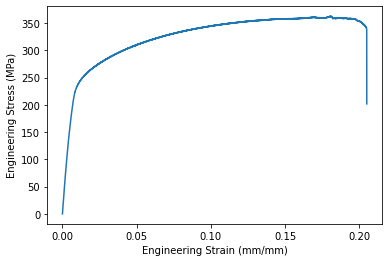

In [173]:
x_label = 'Engineering Strain (mm/mm)'
y_label = 'Engineering Stress (MPa)'
dataset = pd.read_csv(PATH_TO_DATA, sep='\t', names=[x_label, y_label])
x = dataset[x_label]
y = dataset[y_label]

# Remove negative engineering stresses
item = len(x) - 1
while item >=0:
  if y[item] < 0:
    del y[item]
    del x[item]
  item -= 1
x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Group duplicates
x, y = group_by(x, y)
plt.xlabel(x_label)
plt.ylabel(y_label)
_ = plt.plot(x,y)

**Why is the engineering stress negative initially?**

One reason could be the sample is a little longer than the space between the clamps. This results in compression of the specimen initially.

### Fit a linear curve onto the seemingly straight line

Young's Modulus: 21.94611035519921 GPa
Minimum chi squared: 13.235309721590491


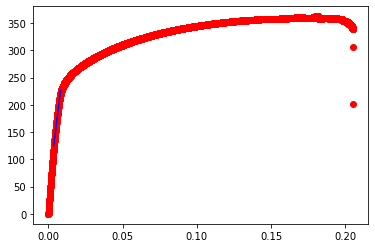

In [174]:
num_points = len(x[:800])

min_fit_length = 400

chi = 0

chi_min = 10000

i_best = 0
j_best = 0

for i in range(len(x[:800]) - min_fit_length):
    for j in range(i+min_fit_length, len(x[:800])):
        start = i
        end = j
        # print(x[i:j], y[i:j])
        coefs = np.polyfit(x[i:j],y[i:j],1)
        y_linear = [i*coefs[0] + coefs[1] for i in x[start:end]]
        chi = 0
        for k in range(i,j):
            chi += ((y_linear[k-start] - y[k])**2)/y[k]

        if chi < chi_min:
            i_best = i
            j_best = j
            chi_min = chi

coefs = np.polyfit(x[i_best:j_best],y[i_best:j_best],1)
y_linear = [i*coefs[0] + coefs[1] for i in x[i_best:j_best]]

youngs_modulus = (y_linear[1] - y_linear[0])/(x[i_best+1] - x[i_best])
print(f'Young\'s Modulus: {youngs_modulus/1000} GPa')
print(f'Minimum chi squared: {chi_min}')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,y,'ro')
ax.plot(x[i_best:j_best],y_linear,'b-')
plt.show()

### Calculating Yield Strength 

Yield Strength: 249.23462 MPa


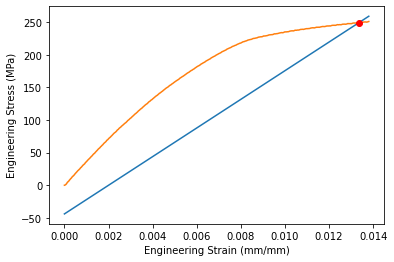

In [192]:
required_points = 1200
parallel_line_y = [(i - 0.002)*youngs_modulus for i in x[:required_points]]
plt.plot(x[:required_points], parallel_line_y)
plt.plot(x[:required_points],y[:required_points])
intersection = np.argwhere(np.diff(np.sign([parallel_line_y[i] - y[i] for i in range(required_points)]))).flatten()
plt.plot(x[intersection[0]], y[intersection[0]], 'ro')
plt.xlabel(x_label)
plt.ylabel(y_label)
yield_strength = y[intersection[0]]
# 0th index because there is only one intersection point
print(f'Yield Strength: {y[intersection[0]]} MPa')

### Calculating Ultimate Tensile Strength

Ultimate Tensile Strength is 362.27072000000004 MPa at 18.095% elongation.


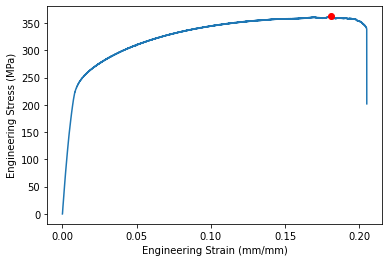

In [189]:
# Fetch the max value of the engineering stress from the dataset.
uts_abscissa = 0
uts = y[uts_abscissa]
for i in range(0,len(y)):
    if y[i] >= uts:
        uts = y[i]
        uts_abscissa = i
uts_strain = x[uts_abscissa]
plt.plot(x,y)
plt.plot(uts_strain, uts, 'ro')
plt.xlabel(x_label)
plt.ylabel(y_label)
print(f'Ultimate Tensile Strength is {uts} MPa at {uts_strain*100}% elongation.')

### Required region for plasticity analysis

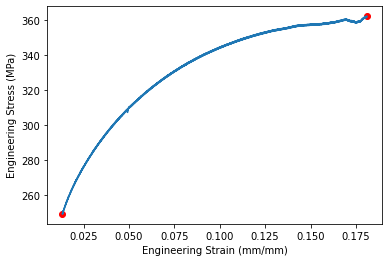

In [193]:
plt.plot(x[intersection[0]], y[intersection[0]], 'ro') # YS
plt.plot(uts_strain, uts, 'ro') # UTS
# there is only one intersection point
start = intersection[0]
end = uts_abscissa+1
plt.plot(x[start:end], y[start:end])
# supresses ouput while setting x,y labels
_ = plt.xlabel(x_label)
_ = plt.ylabel(y_label)

## True Strain v/s True Stress

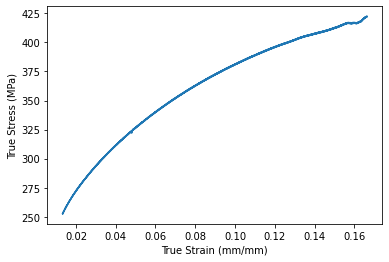

In [194]:
true_strain = np.log([i+1 for i in x[start:end]])
required_points = len(true_strain)
true_stress = [y[start+i]*(1+true_strain[i]) for i in range(required_points)]
_ = plt.plot(true_strain, true_stress)
_ = plt.xlabel('True Strain (mm/mm)')
_ = plt.ylabel('True Stress (MPa)')

## True Plastic Strain v/s True Stress

### Plastic Strain Definition
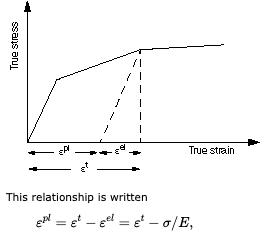

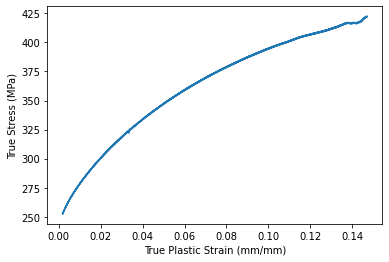

In [195]:
# true plastic strain = true stain - (true stress)/(young's modulus)
true_plastic_strain = [(true_strain[i] - true_stress[i]/youngs_modulus) for i in range(required_points)]
_ = plt.plot(true_plastic_strain, true_stress)
_ = plt.xlabel('True Plastic Strain (mm/mm)')
_ = plt.ylabel('True Stress (MPa)')

## Calculation of work hardening rate

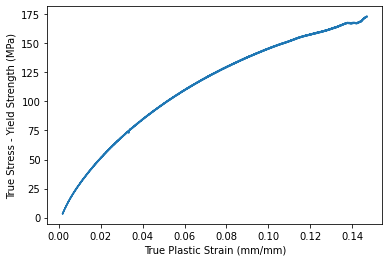

In [196]:
sigma_sigma_ys = [(i-yield_strength) for i in true_stress]
_ = plt.plot(true_plastic_strain, sigma_sigma_ys)
_ = plt.xlabel('True Plastic Strain (mm/mm)')
_ = plt.ylabel('True Stress - Yield Strength (MPa)')

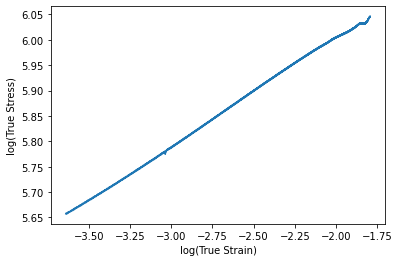

In [197]:
required_points_plasticity = intersection[0] # 965 is the index for the beginning of plastic region.
log_true_strain = np.log(true_strain[required_points_plasticity:]) 
log_true_stress = np.log(true_stress[required_points_plasticity:])
_ = plt.plot(log_true_strain, log_true_stress)
_ = plt.xlabel('log(True Strain)')
_ = plt.ylabel('log(True Stress)')

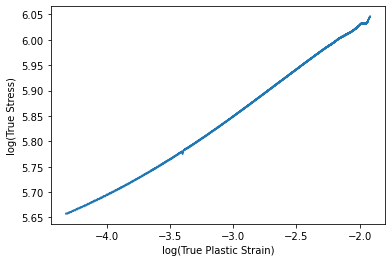

In [198]:
log_true_plastic_strain = np.log(true_plastic_strain[required_points_plasticity:])
_ = plt.plot(log_true_plastic_strain, log_true_stress)
_ = plt.xlabel('log(True Plastic Strain)')
_ = plt.ylabel('log(True Stress)')

$ \sigma = K \times \epsilon^n $
$ \Rightarrow \frac{d\sigma}{d\epsilon} = n \times \frac{\sigma}{\epsilon} $

## Work Hardening Rate plot

$ Work Hardening Rate = \frac{d\sigma}{d\epsilon} = n \times \frac{\sigma}{\epsilon} $

In [199]:
# Determination of work hardening exponent using log(true stress) v/s log(true strain) plot
reshaped_log_true_strain = log_true_strain.reshape((-1, 1))
model = LinearRegression().fit(reshaped_log_true_strain, log_true_stress)
n_plot = model.score(reshaped_log_true_strain, log_true_stress)
Work_hardening_exponent = model.coef_
logk = model.intercept_
print ('Work hardening exponent:', Work_hardening_exponent[0])
print('coefficient of determination:', n_plot)
print('K:', np.exp(logk))

Work hardening exponent: 0.21334985419522604
coefficient of determination: 0.9990834495249493
K: 620.5761375544674


In the plastic region, the true stress and true strain values satisfy:
$ \sigma = 620.576 * \epsilon^{0.212}$


$\frac{d\sigma}{d\epsilon} = n \times \frac {\sigma}{\epsilon} $ 

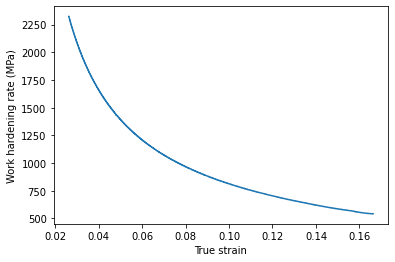

In [200]:
Work_hardening_rate = [Work_hardening_exponent[0]*true_stress[i]/true_strain[i] for i in range(required_points_plasticity, required_points)]
plt.plot(true_strain[required_points_plasticity:], Work_hardening_rate)
_ = plt.ylabel('Work hardening rate (MPa)')
_ = plt.xlabel('True strain')

## Kocks-Mecking Analysis

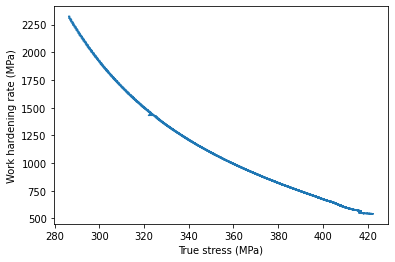

In [202]:
# work hardening rate v/s true stress
_ = plt.plot(true_stress[required_points_plasticity:], Work_hardening_rate)
_ = plt.ylabel('Work hardening rate (MPa)')
_ = plt.xlabel('True stress (MPa)')

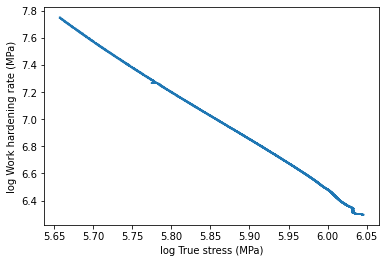

In [203]:
log_work_hardening_rate = np.log(Work_hardening_rate)
_ = plt.plot(log_true_stress, log_work_hardening_rate)
_ = plt.ylabel('log Work hardening rate (MPa)')
_ = plt.xlabel('log True stress (MPa)')

In [204]:
# linear fit
reshaped_log_true_stress = log_true_stress.reshape((-1, 1))
model = LinearRegression().fit(reshaped_log_true_stress, log_work_hardening_rate)
WHrate = model.score(reshaped_log_true_stress, log_work_hardening_rate)
m = model.coef_
c = model.intercept_
print ('m:', m)
print('coefficient of determination:', WHrate)
print('c:', c)
proportionality_constant = np.exp(c)
print ('proportionality constant:', proportionality_constant)

m: [-3.68284102]
coefficient of determination: 0.9985189700994691
c: 28.571107395049737
proportionality constant: 2560202300804.9395


In the plastic region, the work hardening rate and true stress values satisfy:
$ \theta = 2560.2 * \sigma^{-3.7}$ GPa
